# Fourier Transform and Sampling assignment

(1) Make sure you understand the notebook content

(2) With a randomly sampled in the interval [10, 20], build a function f defined in the interval [-10,30] as

f(x) = x(x-a) + 30sin(100πx/a)

for x in [0,a] and 0 otherwise. Compute the Fourier Transform with a sampling rate of 1KHz. Estimate the frequency ωn within which 99.9% of the energy of the FT is contained. Sample f with a frequency equal to π/ωn , 2π/ωn , and 10π/ωn and verify the aliasing effect by plotting the 3 obtained FTs and comparing the 3 inverse FTs with the original signal.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Random value of a: 10.91


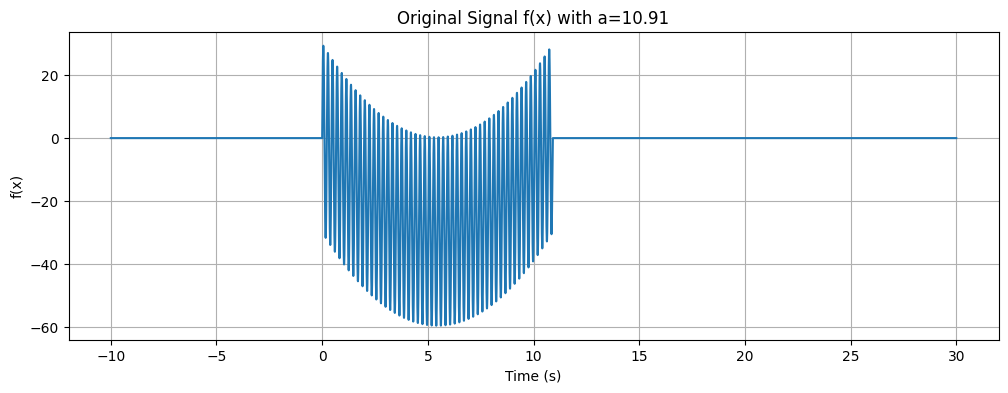

In [78]:
#Generate random 'a' and define the function f(x)
a = np.random.uniform(10, 20)
print(f"Random value of a: {a:.2f}")

#high sampling rate (1 kHz)
sampling_r_high = 1000  # 1 kHz
time_interval = [-10, 30]

# Create time array
time_full = np.arange(time_interval[0], time_interval[1], 1/sampling_r_high)

# Define function f(x)
def f(x, a):
    """
    f(x) = x(x-a) + 30*sin(100*pi*x/a) for x in [0,a]
    f(x) = 0 otherwise
    """
    result = np.zeros_like(x)
    mask = (x >= 0) & (x <= a)
    result[mask] = x[mask] * (x[mask] - a) + 30 * np.sin(100 * np.pi * x[mask] / a)
    return result

# Generate the signal
y_original = f(time_full, a)

# Plot the original signal
plt.figure(figsize=(12, 4))
plt.plot(time_full, y_original)
plt.xlabel('Time (s)')
plt.ylabel('f(x)')
plt.title(f'Original Signal f(x) with a={a:.2f}')
plt.grid(True)
plt.show()

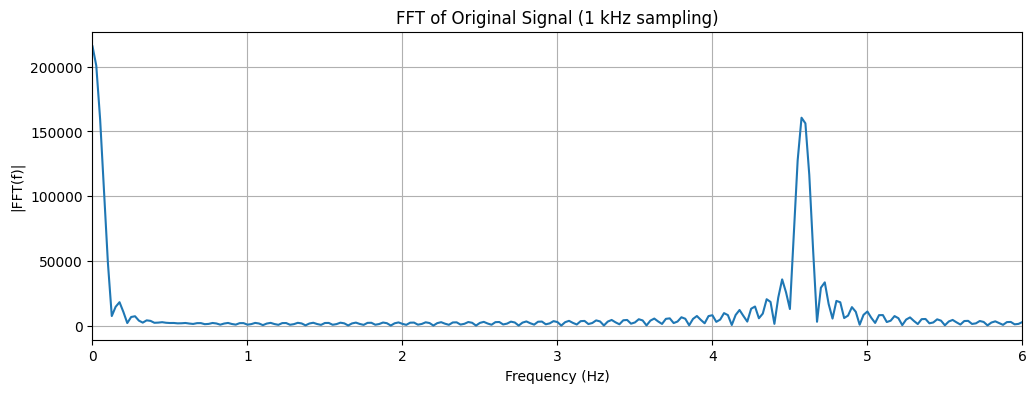

In [79]:
# Compute FFT at 1 kHz sampling rate
fft_original = np.fft.fft(y_original)
N_original = len(y_original)
freq_original = np.fft.fftfreq(N_original, 1/sampling_r_high)

# Shift for better visualization
fft_original_shifted = np.fft.fftshift(fft_original)
freq_original_shifted = np.fft.fftshift(freq_original)

# Plot the FFT
plt.figure(figsize=(12, 4))
plt.plot(freq_original_shifted, np.abs(fft_original_shifted))
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT(f)|')
plt.title('FFT of Original Signal (1 kHz sampling)')
plt.grid(True)
plt.xlim([0, 6])
plt.show()

In [80]:
# Estimate frequency ωn containing 99.9% of energy
# Compute energy spectrum (squared magnitude)
energy_spectrum = np.abs(fft_original)**2
total_energy = np.sum(energy_spectrum)

# Sort frequencies by energy contribution
sorted_indices = np.argsort(energy_spectrum)[::-1]
cumulative_energy = np.cumsum(energy_spectrum[sorted_indices])

# Find the frequency where 99.9% of energy is contained
threshold = 0.999 * total_energy
idx_999 = np.where(cumulative_energy >= threshold)[0][0]

# Get the maximum frequency needed for 99.9% energy
freq_contributing = np.abs(freq_original[sorted_indices[:idx_999+1]])
omega_n = np.max(freq_contributing)  # This is the frequency (in Hz)
omega_n_rad = 2 * np.pi * omega_n  # Convert to rad/s

print(f"Frequency containing 99.9% of energy:")
print(f"  ω_n = {omega_n:.2f} Hz")
print(f"  ω_n = {omega_n_rad:.2f} rad/s")
print(f"  Nyquist frequency (2*ω_n) = {2 * omega_n:.2f} Hz")

Frequency containing 99.9% of energy:
  ω_n = 6.65 Hz
  ω_n = 41.78 rad/s
  Nyquist frequency (2*ω_n) = 13.30 Hz


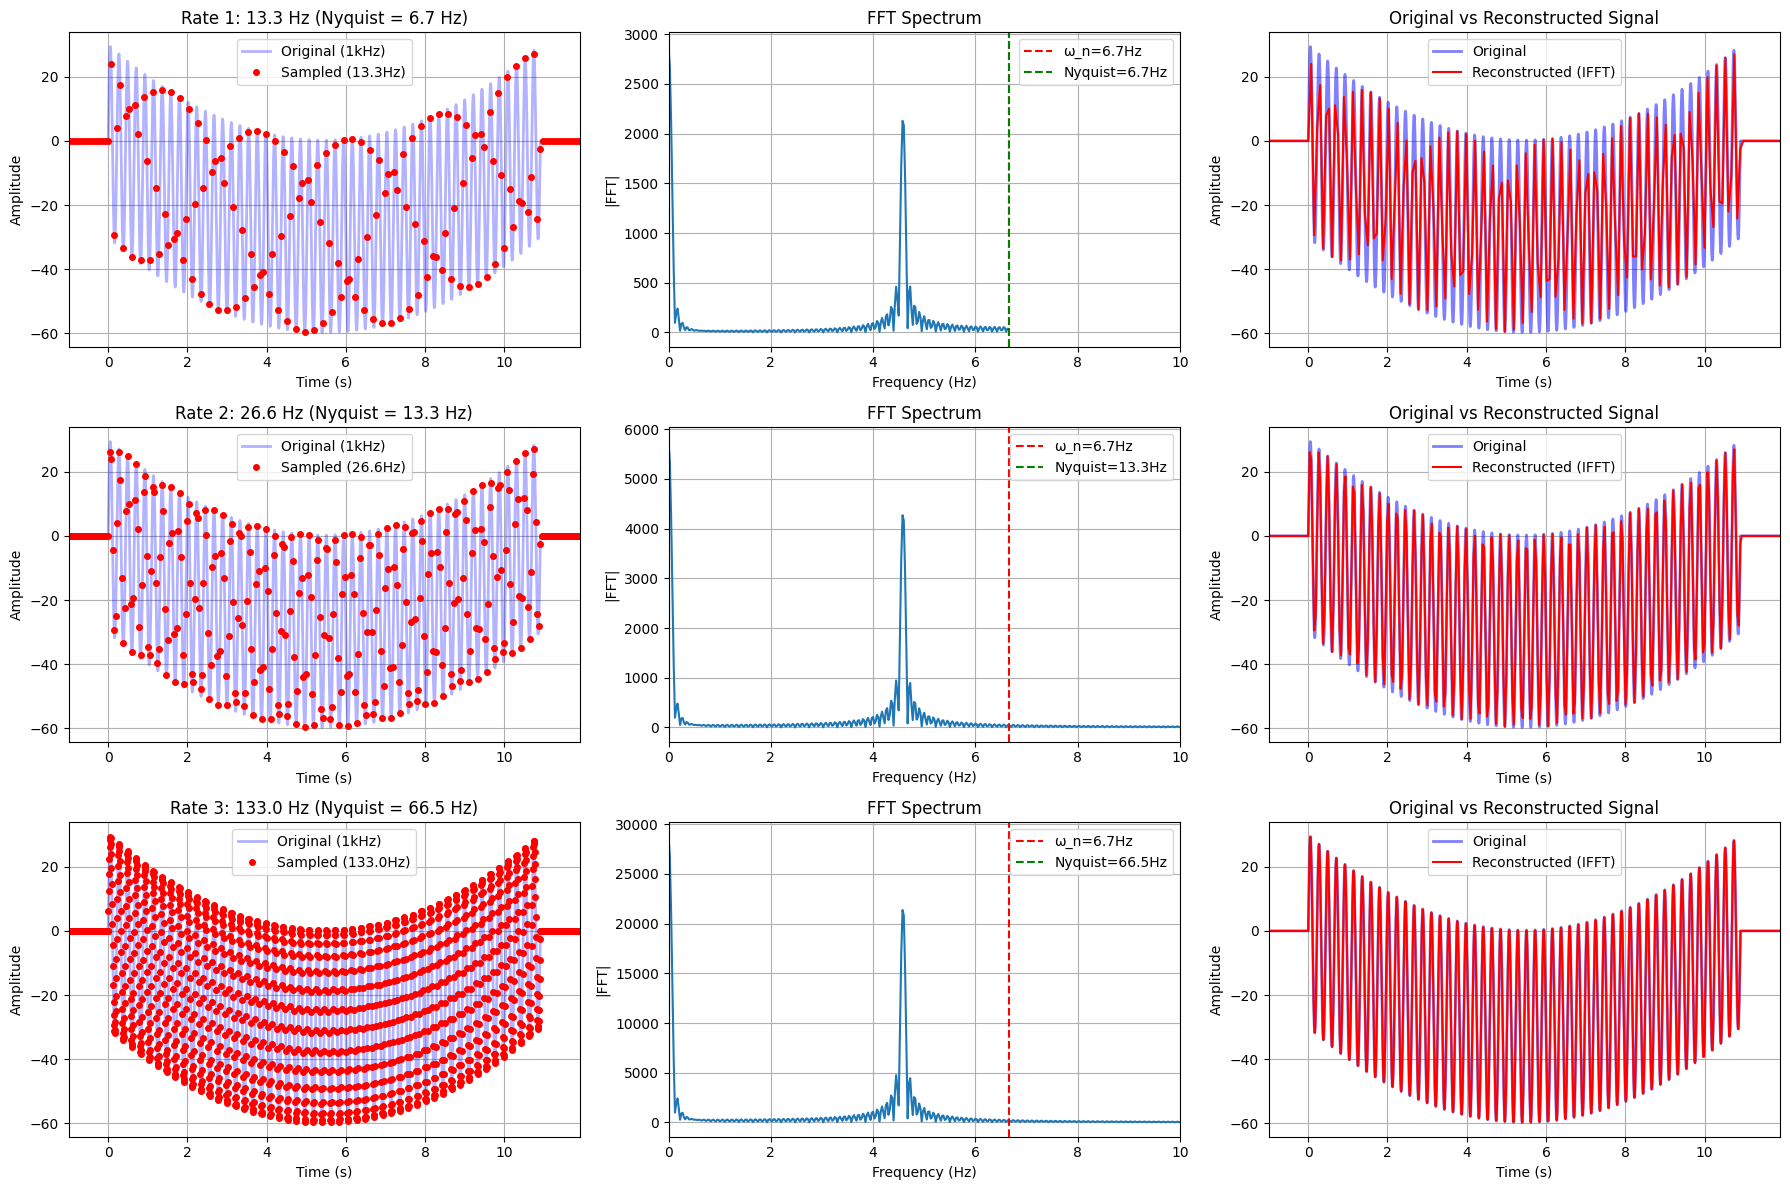

In [81]:
# Sample at three different rates and observe aliasing
# Define the three sampling rates based on ωn (in rad/s)
sampling_rates_test = [
    omega_n_rad / np.pi,      # π/ωn → ωn/π Hz (undersampling)
    2 * omega_n_rad / np.pi,  # 2π/ωn → 2ωn/π Hz (at Nyquist limit)
    10 * omega_n_rad / np.pi  # 10π/ωn → 10ωn/π Hz 
]

# Create figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for idx, sampling_r_test in enumerate(sampling_rates_test):
    # Resample the signal
    time_test = np.arange(time_interval[0], time_interval[1], 1/sampling_r_test)
    y_test = f(time_test, a)
    
    # Compute FFT
    fft_test = np.fft.fft(y_test)
    N_test = len(y_test)
    freq_test = np.fft.fftshift(np.fft.fftfreq(N_test, 1/sampling_r_test))
    fft_test_shifted = np.fft.fftshift(fft_test)
    
    # Compute inverse FFT
    y_reconstructed = np.fft.ifft(fft_test)
    
    # Plot 1: Original vs Sampled Signal
    axes[idx, 0].plot(time_full, y_original, 'b-', alpha=0.3, linewidth=2, label='Original (1kHz)')
    axes[idx, 0].plot(time_test, y_test, 'ro', markersize=4, label=f'Sampled ({sampling_r_test:.1f}Hz)')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].set_title(f'Rate {idx+1}: {sampling_r_test:.1f} Hz (Nyquist = {sampling_r_test/2:.1f} Hz)')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True)
    axes[idx, 0].set_xlim([-1, a+1])
    
    # Plot 2: FFT Magnitude
    axes[idx, 1].plot(freq_test, np.abs(fft_test_shifted))
    axes[idx, 1].axvline(x=omega_n, color='r', linestyle='--', label=f'ω_n={omega_n:.1f}Hz')
    axes[idx, 1].axvline(x=-omega_n, color='r', linestyle='--')
    axes[idx, 1].axvline(x=sampling_r_test/2, color='g', linestyle='--', label=f'Nyquist={sampling_r_test/2:.1f}Hz')
    axes[idx, 1].axvline(x=-sampling_r_test/2, color='g', linestyle='--')
    axes[idx, 1].set_xlabel('Frequency (Hz)')
    axes[idx, 1].set_ylabel('|FFT|')
    axes[idx, 1].set_title(f'FFT Spectrum')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True)
    axes[idx, 1].set_xlim([0, 10])
    
    # Plot 3: Reconstructed vs Original
    axes[idx, 2].plot(time_full, y_original, 'b-', alpha=0.5, linewidth=2, label='Original')
    axes[idx, 2].plot(time_test, np.real(y_reconstructed), 'r-', linewidth=1.5, label='Reconstructed (IFFT)')
    axes[idx, 2].set_xlabel('Time (s)')
    axes[idx, 2].set_ylabel('Amplitude')
    axes[idx, 2].set_title('Original vs Reconstructed Signal')
    axes[idx, 2].legend()
    axes[idx, 2].grid(True)
    axes[idx, 2].set_xlim([-1, a+1])

plt.tight_layout()
plt.show()